# download packages

In [1]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
!pip install plotly

# Import the libraries

In [3]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# prepare train test splits

In [4]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [5]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


# prepare the training plan

In [6]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# test the model

In [7]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

# training curves plot

In [8]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [9]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [10]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [11]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [12]:
data = pd.read_csv(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/",'HAM10000_metadata.csv'))

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


# Exploratory Data Analysis

In [13]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [15]:
data.isnull().any().sum()

1

<Figure size 720x720 with 0 Axes>

<AxesSubplot:xlabel='dx', ylabel='count'>

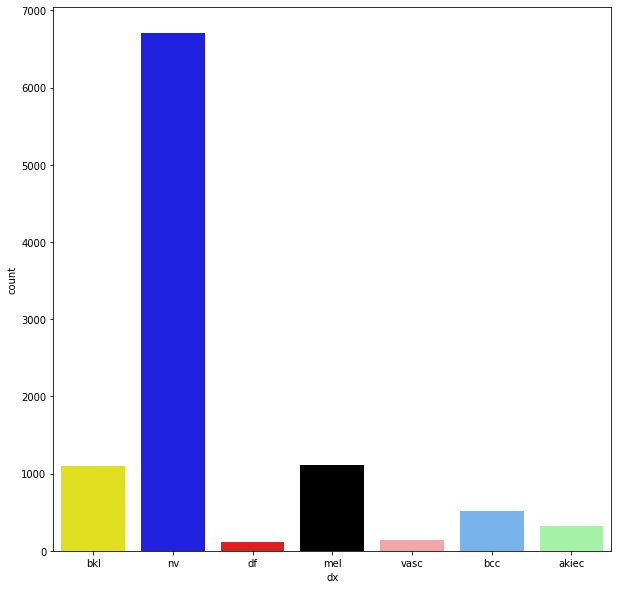

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(x='dx', palette=['yellow', 'blue','red','black','#ff9999', '#66b3ff', '#99ff99'], data=data)
plt.show()

<AxesSubplot:xlabel='age'>

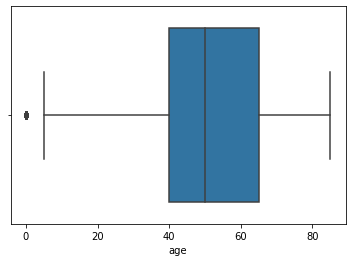

In [17]:
sns.boxplot(data['age'])

<Figure size 360x360 with 0 Axes>

<AxesSubplot:ylabel='sex'>

Text(0.5, 1.0, 'SEX')

Text(0, 0.5, '')

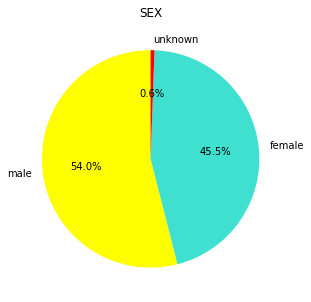

In [18]:
plt.figure(figsize=(5,5))
data['sex'].value_counts().plot.pie(autopct='%1.1f%%',startangle=90,colors=['YELLOW','#40E0D0','r',])
plt.title('SEX')
plt.ylabel('')
plt.show()

<Figure size 1296x720 with 0 Axes>

<AxesSubplot:xlabel='localization', ylabel='count'>

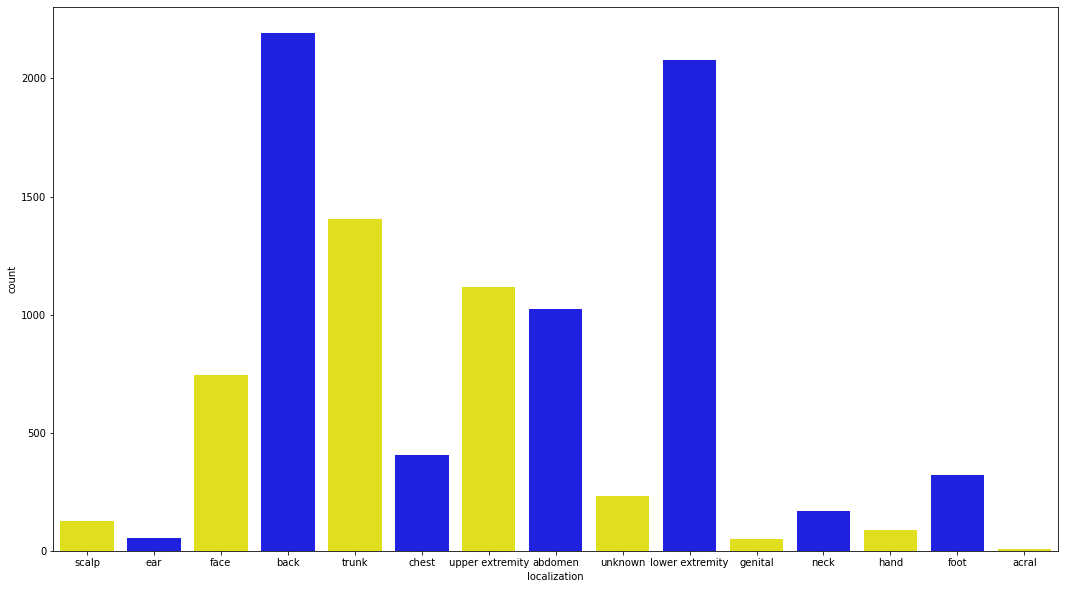

In [19]:
plt.figure(figsize=(18,10))
sns.countplot(x='localization', palette=['yellow', 'blue'], data=data)
plt.show()

# Imputing the Null values and preparing the data

In [20]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [21]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [22]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...


In [23]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [24]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


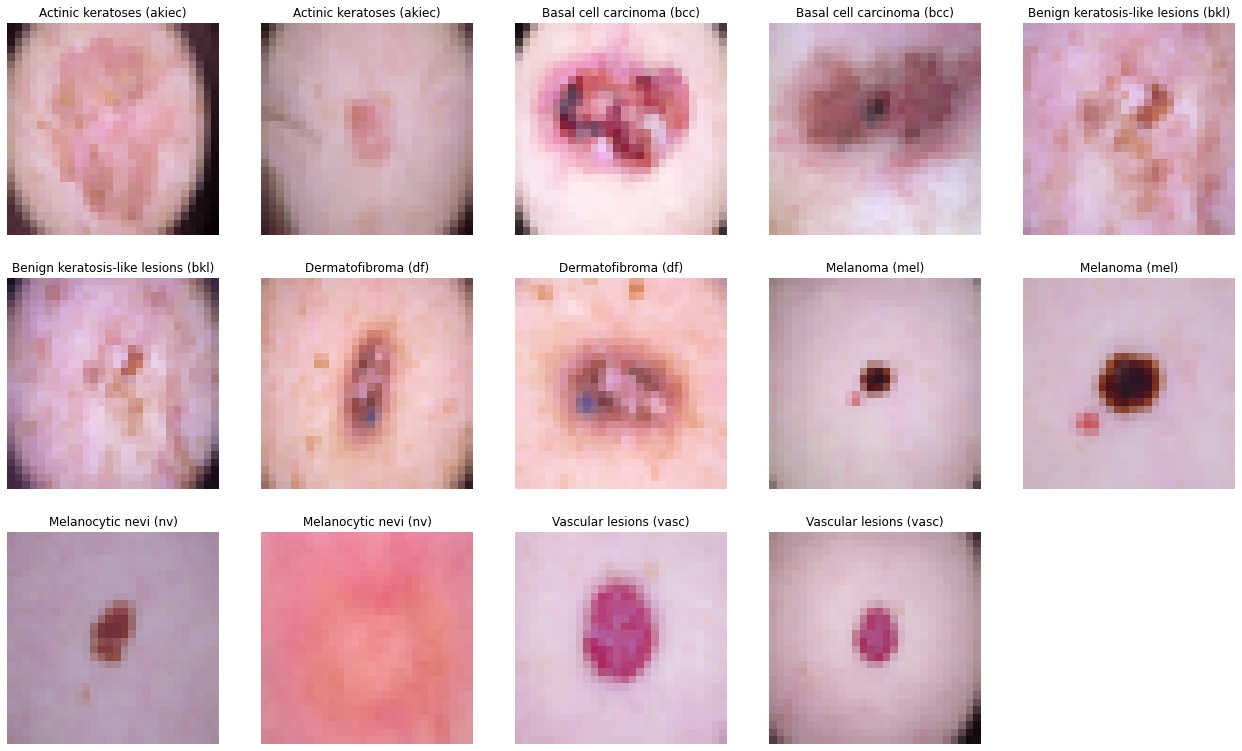

In [25]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [26]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [27]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [28]:
len(frames)

7

In [29]:
final_data = pd.concat(frames)

In [30]:
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)


In [31]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [32]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


<AxesSubplot:ylabel='Count'>

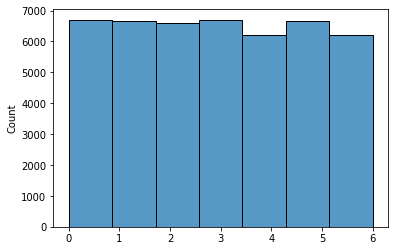

In [33]:
sns.histplot(Y_aug.flatten(), bins=7)

plt.show()

In [34]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [35]:
model =create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [36]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [37]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 9s 4ms/step - loss: 1.4319 - accuracy: 0.4966 - val_loss: 0.8948 - val_accuracy: 0.6544
Epoch 2/50
458/458 [==============================] - 2s 4ms/step - loss: 0.7356 - accuracy: 0.7214 - val_loss: 0.5598 - val_accuracy: 0.7824
Epoch 3/50
458/458 [==============================] - 2s 4ms/step - loss: 0.4734 - accuracy: 0.8219 - val_loss: 0.4306 - val_accuracy: 0.8428
Epoch 4/50
458/458 [==============================] - 2s 4ms/step - loss: 0.3578 - accuracy: 0.8670 - val_loss: 0.3423 - val_accuracy: 0.8760
Epoch 5/50
458/458 [==============================] - 2s 4ms/step - loss: 0.2995 - accuracy: 0.8893 - val_loss: 0.2895 - val_accuracy: 0.8899
Epoch 6/50
458/458 [==============================] - 2s 4ms/step - loss: 0.2162 - accuracy: 0.9195 - val_loss: 0.2328 - val_accuracy: 0.9172
Epoch 7/50
458/458 [==============================] - 2s 4ms/step - loss: 0.2154 - accuracy: 0.9230 - val_loss: 0.2694 - val_accuracy: 0.9104
Epoch 

In [38]:
model

# save model

In [39]:
# model.save('Skin_Cancer.sav')
model.save('my_model.h5')

# save model weights

In [40]:
# model.save_weights("Skin_Cancer.hdf5")

In [41]:
# from IPython.display import FileLink
# FileLink('Skin_Cancer.hdf5')

In [42]:
plot_model_training_curve(model2_history)

Test Accuracy: 96.855%
              precision    recall  f1-score   support

          nv       1.00      0.96      0.98      1374
         mel       0.86      0.99      0.92       205
         bkl       0.91      1.00      0.95       227
         bcc       0.98      1.00      0.99        94
       akiec       0.98      1.00      0.99        55
        vasc       0.93      1.00      0.97        28
          df       1.00      1.00      1.00        20

    accuracy                           0.97      2003
   macro avg       0.95      0.99      0.97      2003
weighted avg       0.97      0.97      0.97      2003



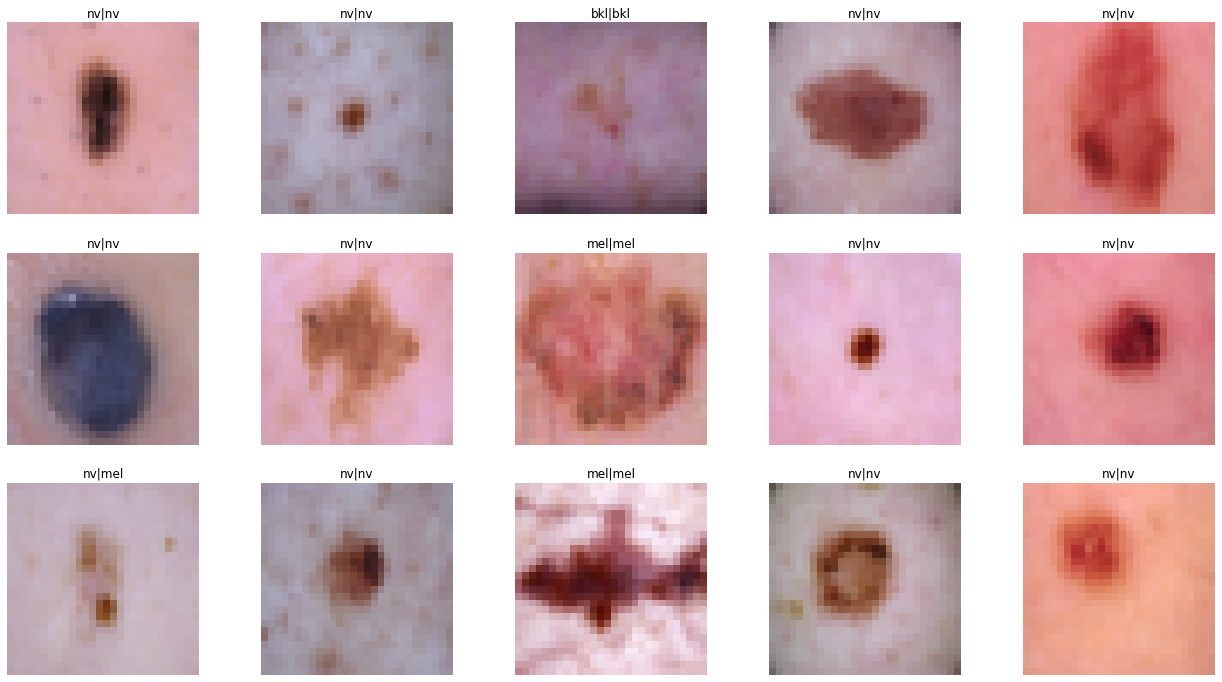

In [43]:
test_model(model, X_test_orig, Y_test_orig)

In [44]:
data.head(2)
data.iloc[8000]

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0


index                                                          93
lesion_id                                             HAM_0004852
image_id                                             ISIC_0028774
dx                                                            bkl
dx_type                                                     histo
age                                                            65
sex                                                          male
localization                                                 face
cell_type                     Benign keratosis-like lesions (bkl)
path            ../input/skin-cancer-mnist-ham10000/ham10000_i...
image_pixel     [[[134, 93, 100], [138, 96, 103], [139, 93, 87...
label                                                           2
Name: 8000, dtype: object

In [45]:
'''單張圖片的預測1'''
one_picture_predict_data = data.iloc[10000]
print(one_picture_predict_data)
print(f"real is {one_picture_predict_data.dx}")
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
print(f"argmax value is {np.argmax(model.predict(new_one)[0])}")
model.predict(new_one)[0]

'單張圖片的預測1'

index                                                        1165
lesion_id                                             HAM_0005584
image_id                                             ISIC_0032613
dx                                                             df
dx_type                                                 consensus
age                                                            25
sex                                                        female
localization                                      lower extremity
cell_type                                     Dermatofibroma (df)
path            ../input/skin-cancer-mnist-ham10000/ham10000_i...
image_pixel     [[[158, 146, 166], [172, 161, 181], [179, 168,...
label                                                           6
Name: 10000, dtype: object
real is df
6


(28, 28, 3)

argmax value is 6


array([2.6757424e-10, 6.3268672e-14, 9.3152263e-17, 1.7876680e-18,
       2.0705819e-21, 1.6489918e-15, 1.0000000e+00], dtype=float32)

In [46]:
'''單張圖片的預測2'''
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

'單張圖片的預測2'

../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027032.jpg


(450, 600, 3)

(1, 450, 600, 3)

array([[2.6757424e-10, 6.3268672e-14, 9.3152263e-17, 1.7876680e-18,
        2.0705819e-21, 1.6489918e-15, 1.0000000e+00]], dtype=float32)

# Create confusion matrix

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 33.0, 'Predicted Label')

Text(51.0, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix')

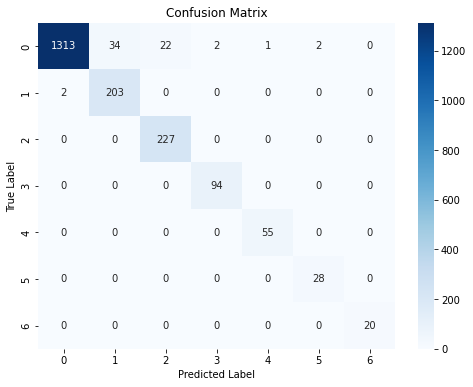

In [50]:
y_pred = model.predict(X_test_orig)
prediction_arr = []

for i in range(y_pred.shape[0]):
    pred_idx = np.argmax(y_pred[i])
    prediction_arr.append(pred_idx)
    
prediction_arr = np.array(prediction_arr)
real_arr = Y_test_orig.flatten()

cm = confusion_matrix(real_arr, prediction_arr, labels=[0, 1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5, 6], yticklabels=[0, 1, 2, 3, 4, 5, 6])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()